## Observations:

zip is available in address - index on split is -1, -5:

potential interests:

- zip code (reduced to large(-ish?) sample sizes)
- maybe look at geographical location specifically? (Is proximity to city center and features calculable?| $\checkmark$)
  - look into part 2 ^
  - waterfront is listed as a binary column
- (person pref, focus on home buyers/individuals)
- someone mentioned school data - this isn't a bad idea.
  - can get school rankings and their zip codes

would like to get external/additional information. Will check Kaggle for related data sets

https://kingcounty.gov/ <= city website

find out if prices are based on closes or valuations - if closes, can

### Data cleaning

- multiple y/n / cat. columns that can be converted to dummies for OLS discovery
- view quality can be rated as good/bad/avg. , could be extrapolated to 0-2 (more if more options there)
- grade?

<hr/>
Data from [column_names.md](data/column_names.md)  
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

- `view` - Quality of view from house
  - Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
- `condition` - How good the overall condition of the house is. Related to maintenance of house.
  - See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
- `grade` - Overall grade of the house. Related to the construction and design of the house.
  - See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
  <hr/>

lots of relevant info for discovery in there


# _*IMPORTANT*_

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model

<br/><hr/><br/><hr/>


excluding < 400sqft, tiny home by definition per:
"A dwelling unit that is 400 square feet (37 m2) or less in floor area excluding sleeping lofts"
src: https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf


### imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from code.features import has_feature


dfs:  
    housing data - provided by FlatIron School  
    zip codes: cross referenced with zip-codes.com  
    nearby_zips - pulled from https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/

In [2]:
housing_df = pd.read_csv('data/kc_house_data.csv')
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv')
nearby_zips_df = pd.read_csv('data/zips_5_mile.csv')

## Base Variable Definitions


define seaborn theme as on


In [3]:
sns.set()


In [4]:
alpha = 0.05            # default confidence
upper_cost = 5000000    # <= $5,000,000


## ALL DF Definitions

merge these more cleanly in the index


bring in zip codes from _*ONLY*_ King County (data from: https://www.zip-codes.com/county/wa-king.asp) and take out any data outside of the county


In [5]:
housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
housing_df['town'] = housing_df['address'].map(
    lambda x: x.split(',')[-3].strip())
housing_df.drop(columns=['address', 'lat', 'long'], inplace=True)
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(
    str), left_on='zip', right_on='Zip Codes', how='inner')


In [6]:
display(kc_only.info(), kc_only.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29189 entries, 0 to 29188
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29189 non-null  int64  
 1   date           29189 non-null  object 
 2   price          29189 non-null  float64
 3   bedrooms       29189 non-null  int64  
 4   bathrooms      29189 non-null  float64
 5   sqft_living    29189 non-null  int64  
 6   sqft_lot       29189 non-null  int64  
 7   floors         29189 non-null  float64
 8   waterfront     29189 non-null  object 
 9   greenbelt      29189 non-null  object 
 10  nuisance       29189 non-null  object 
 11  view           29189 non-null  object 
 12  condition      29189 non-null  object 
 13  grade          29189 non-null  object 
 14  heat_source    29160 non-null  object 
 15  sewer_system   29176 non-null  object 
 16  sqft_above     29189 non-null  int64  
 17  sqft_basement  29189 non-null  int64  
 18  sqft_g

None

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,2.918900e+04,2.918900e+04,29189.000000,29189.000000,29189.000000,2.918900e+04,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000
mean,4.535750e+09,1.113059e+06,3.435335,2.331889,2130.911987,1.720745e+04,1.516564,1825.949844,480.890747,336.257666,216.342972,1973.827401,93.931344
std,2.882323e+09,8.957550e+05,0.978759,0.896124,977.502626,6.131060e+04,0.548233,880.928042,586.056457,286.283099,246.810496,31.681435,422.974700
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000
50%,3.874000e+09,8.685000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000
75%,7.287100e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.078400e+04,2.000000,2290.000000,960.000000,510.000000,310.000000,2001.000000,0.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000


reduce df down to only houses that are not legally considered tiny homes, have bedrooms, and have at least a half-bath  
also, remove the lat and long columns - they are not being used  
<sub>come back to this later to clean data for visibility if necessary</sub>

output to homes_df variable


convert features from sqft to binary have/have-not column  
because this is in 1 and 0, this doesn't need to be dummied and dropped


In [7]:
new_columns = ['has_basement', 'has_garage', 'has_patio', 'is_renovated']
check_columns = ['sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_renovated']
kc_only[new_columns] = kc_only[check_columns].apply(has_feature)
kc_only.drop(columns=check_columns, inplace=True)
kc_only.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,yr_built,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,1969,98055,Renton,98055,0,0,1,0
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,PUBLIC,930,1950,98055,Renton,98055,1,1,1,1
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,PUBLIC,1240,1973,98055,Renton,98055,1,1,1,0
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,PUBLIC,1400,1971,98055,Renton,98055,0,1,1,0
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,PUBLIC,1190,1981,98055,Renton,98055,1,1,1,0


create homes_df from kc_only ; include only sqft > 400 (tiny home max. sqft), has bedroom, has bath, price < upper_cost (default $5,000,000)  
drop unnecessary columns


In [8]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) &
                   (kc_only['bedrooms'] > 0) &
                   (kc_only['bathrooms'] > 0) &
                   (kc_only['price'] < upper_cost)      # <= dropping houses valued at and over $5,000,000 - most demographics will not be looking for this.
                   ]


In [9]:
# get zip codes that have at least 100 entries

zip_counts = homes_df['zip'].value_counts().rename('zip_counts')
zips_counted = homes_df.merge(
    zip_counts,
    left_on='zip',
    right_index=True
)
zips_counted.info()
min_zips = zips_counted[zips_counted['zip_counts'] >= 100]
min_zips


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            28919 non-null  int64  
 1   date          28919 non-null  object 
 2   price         28919 non-null  float64
 3   bedrooms      28919 non-null  int64  
 4   bathrooms     28919 non-null  float64
 5   sqft_living   28919 non-null  int64  
 6   sqft_lot      28919 non-null  int64  
 7   floors        28919 non-null  float64
 8   waterfront    28919 non-null  object 
 9   greenbelt     28919 non-null  object 
 10  nuisance      28919 non-null  object 
 11  view          28919 non-null  object 
 12  condition     28919 non-null  object 
 13  grade         28919 non-null  object 
 14  heat_source   28899 non-null  object 
 15  sewer_system  28908 non-null  object 
 16  sqft_above    28919 non-null  int64  
 17  yr_built      28919 non-null  int64  
 18  zip           28919 non-nu

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,yr_built,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,zip_counts
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,1969,98055,Renton,98055,0,0,1,0,219
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,930,1950,98055,Renton,98055,1,1,1,1,219
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,1240,1973,98055,Renton,98055,1,1,1,0,219
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,1400,1971,98055,Renton,98055,0,1,1,0,219
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,1190,1981,98055,Renton,98055,1,1,1,0,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29092,723039050,12/16/2021,1826000.0,2,3.0,2070,71264,2.0,NO,NO,...,2070,2001,98070,Vashon,98070,1,1,1,0,193
29093,2022039037,4/14/2022,256000.0,2,1.0,1330,113815,1.0,NO,NO,...,1330,1911,98070,Vashon,98070,0,1,0,1,193
29094,2322039033,7/14/2021,950000.0,2,2.5,1960,11406,2.0,NO,NO,...,1960,1938,98070,Vashon,98070,1,1,1,1,193
29095,3023039221,9/21/2021,450000.0,2,2.0,840,138520,1.0,NO,NO,...,840,2020,98070,Vashon,98070,0,0,1,0,193


In [10]:
# reduce df to only zip codes with at least 100 reported houses
zip_by_price_median = min_zips[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
zip_by_price_median.sort_values('price', ascending=False, inplace=True)
zip_by_price_median


,zip,price,count
3,98004,2672500.0,258
24,98040,2300000.0,323
4,98005,1956000.0,178
21,98033,1832687.5,600
38,98075,1830500.0,410
...,...,...,...
12,98022,567230.0,454
2,98003,550000.0,439
20,98032,549950.0,183
63,98168,540000.0,383


In [17]:
y = homes_df['price']
X = sm.add_constant(
    pd.get_dummies(homes_df['zip']).drop(
        zip_by_price_median.iloc[0]['zip'],         # <= selectl the highest-(median) priced zip to drop it
        axis=1
    ))

zip_model = sm.OLS(np.log(y), X).fit().summary2()
display(zip_by_price_median.iloc[0],print(zip_model))


                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.446     
Dependent Variable: price            AIC:                31726.1058
Date:               2023-03-29 14:08 BIC:                32354.7971
No. Observations:   28919            Log-Likelihood:     -15787.   
Df Model:           75               F-statistic:        310.8     
Df Residuals:       28843            Prob (F-statistic): 0.00      
R-squared:          0.447            Scale:              0.17492   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      14.7461     0.0260   566.3280   0.0000   14.6950   14.7971
98001      -1.4719     0.0310   -47.5374   0.0000   -1.5326   -1.4112
98002      -1.7263     0.0340   -50.7191   0.0000   -1.7930   -1.6596
98003      -1.5283     0.0328   -46.5817   0.0000   -1

zip           98004
price    2.6725e+06
count           258
Name: 3, dtype: object

None

model shows strong relation

look at highest zip (98004, already checked) - find adjacent zips (5 mile radius) and run from there

### zip 98004, Bellevue:
![Image of King County by Zip code centered on Bellevue (98004)](./img/kc_counties_98004.png)  
<sup>source: [https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98]('https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98')</sup>

### Counties within 5 miles of 98004:
![Image of King County by Zip code centered on Bellevue (98004)](./img/kc_counties_98004_prox.png)  
<sup>source: [https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98]('https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98')</sup>

limit to nearby zips

In [18]:
nearby_zips_df['ZIPCODE'] = nearby_zips_df['ZIPCODE'].astype(str)
nearby_homes_df = min_zips.merge(nearby_zips_df,how='inner',left_on='zip',right_on='ZIPCODE').drop(
    columns=['ZIP','ZIPCODE','PREFERRED_CITY']      #<= dropping columns from nearby_zips_df, they're redundant
    )
nearby_homes_df


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,yr_built,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,zip_counts
0,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,2010,98118,Seattle,98118,1,1,1,0,600
1,4006000502,10/27/2021,700000.0,6,3.5,1810,8519,1.0,NO,NO,...,1080,1965,98118,Seattle,98118,1,1,1,0,600
2,5249802390,3/3/2022,274380.0,2,1.0,1440,4000,1.0,NO,NO,...,720,1920,98118,Seattle,98118,1,0,1,1,600
3,1105000058,10/28/2021,599000.0,4,2.0,1510,5013,1.5,NO,NO,...,1510,1905,98118,Seattle,98118,0,0,1,1,600
4,1704900215,5/12/2022,1100000.0,3,2.0,1740,4883,1.0,NO,NO,...,870,1923,98118,Seattle,98118,1,0,1,1,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,9550204160,6/30/2021,835000.0,4,2.0,2280,3640,1.5,NO,NO,...,1680,1929,98105,Seattle,98105,1,1,0,0,323
8104,3131200640,6/24/2021,1250000.0,3,2.0,1830,4590,2.0,NO,NO,...,1830,1908,98105,Seattle,98105,1,0,1,0,323
8105,3179100575,10/13/2021,1190000.0,3,2.0,2060,6469,1.0,NO,NO,...,1030,1950,98105,Seattle,98105,1,1,1,0,323
8106,2862100450,6/24/2021,1160000.0,5,3.0,1740,4400,1.0,NO,NO,...,990,1918,98105,Seattle,98105,1,1,1,0,323


In [14]:
nearby_zip_by_price_median = nearby_homes_df[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
nearby_zip_by_price_median.sort_values('price', ascending=False, inplace=True)
nearby_zip_by_price_median

,zip,price,count
0,98004,2672500.0,258
7,98040,2300000.0,323
1,98005,1956000.0,178
5,98033,1832687.5,600
2,98006,1638000.0,517
8,98052,1460000.0,567
12,98112,1427500.0,296
4,98008,1320000.0,394
3,98007,1260000.0,154
11,98105,1160000.0,323


In [43]:
y = nearby_homes_df['price']
X = sm.add_constant(
    pd.get_dummies(nearby_homes_df['zip']).drop(
        '98004',         # <= drop 98004, highest cost
        axis=1
    ))
y = np.log(y)
nearby_zip_model = sm.OLS(y, X).fit().summary2()
print(nearby_zip_model)

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.331     
Dependent Variable: price            AIC:                10253.5423
Date:               2023-03-29 14:33 BIC:                10379.5532
No. Observations:   8108             Log-Likelihood:     -5108.8   
Df Model:           17               F-statistic:        237.4     
Df Residuals:       8090             Prob (F-statistic): 0.00      
R-squared:          0.333            Scale:              0.20691   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      14.7461     0.0283   520.7102   0.0000   14.6906   14.8016
98005      -0.2484     0.0443    -5.6043   0.0000   -0.3353   -0.1615
98006      -0.4311     0.0347   -12.4326   0.0000   -0.4990   -0.3631
98007      -0.6610     0.0463   -14.2710   0.0000   -0

# RUN FROM HERE UP


''

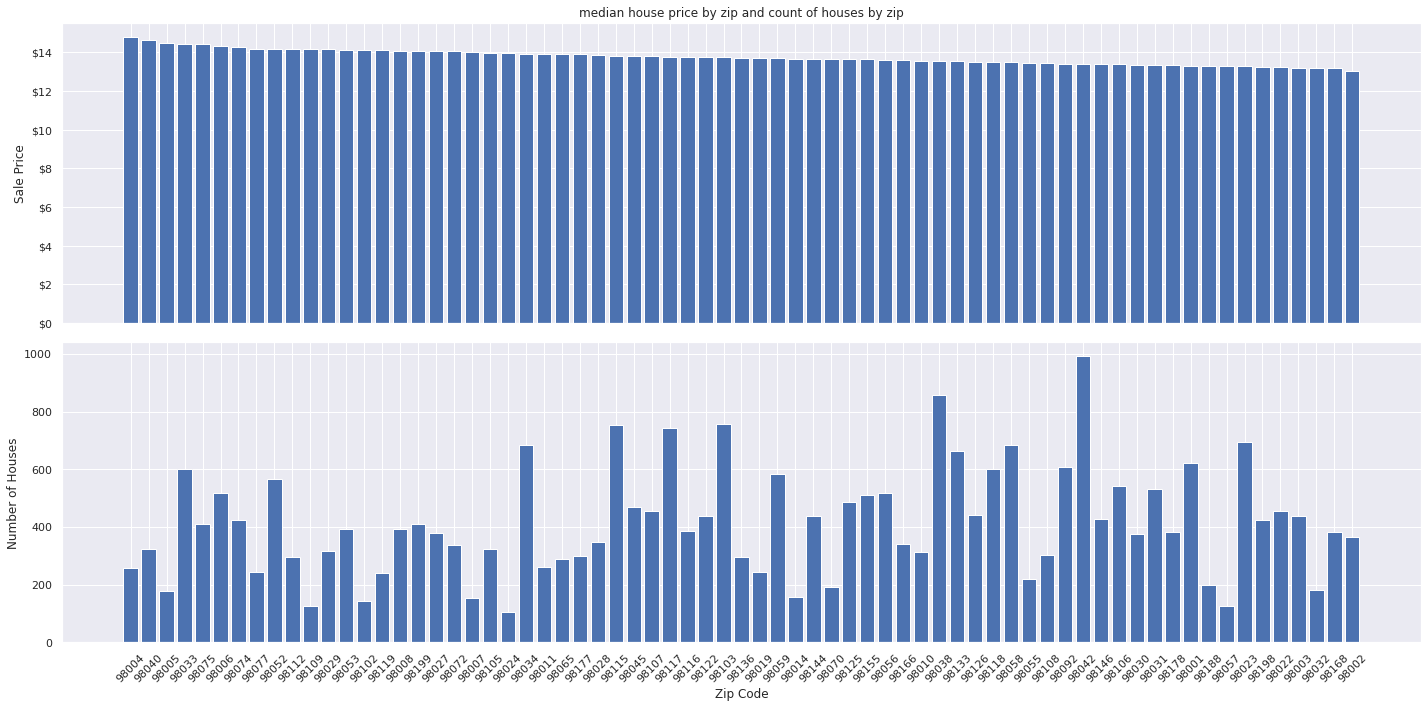

In [19]:
# plot of FULL dataset values

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

y = [zip_by_price_median['price'], zip_by_price_median['count']]
x = zip_by_price_median['zip']

ax[0].bar(x=x, height=np.log(y[0]))
ax[1].bar(x=x, height=y[1])

ax[0].set(
    title='median house price by zip and count of houses by zip',
    ylabel='Sale Price'
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
''


''

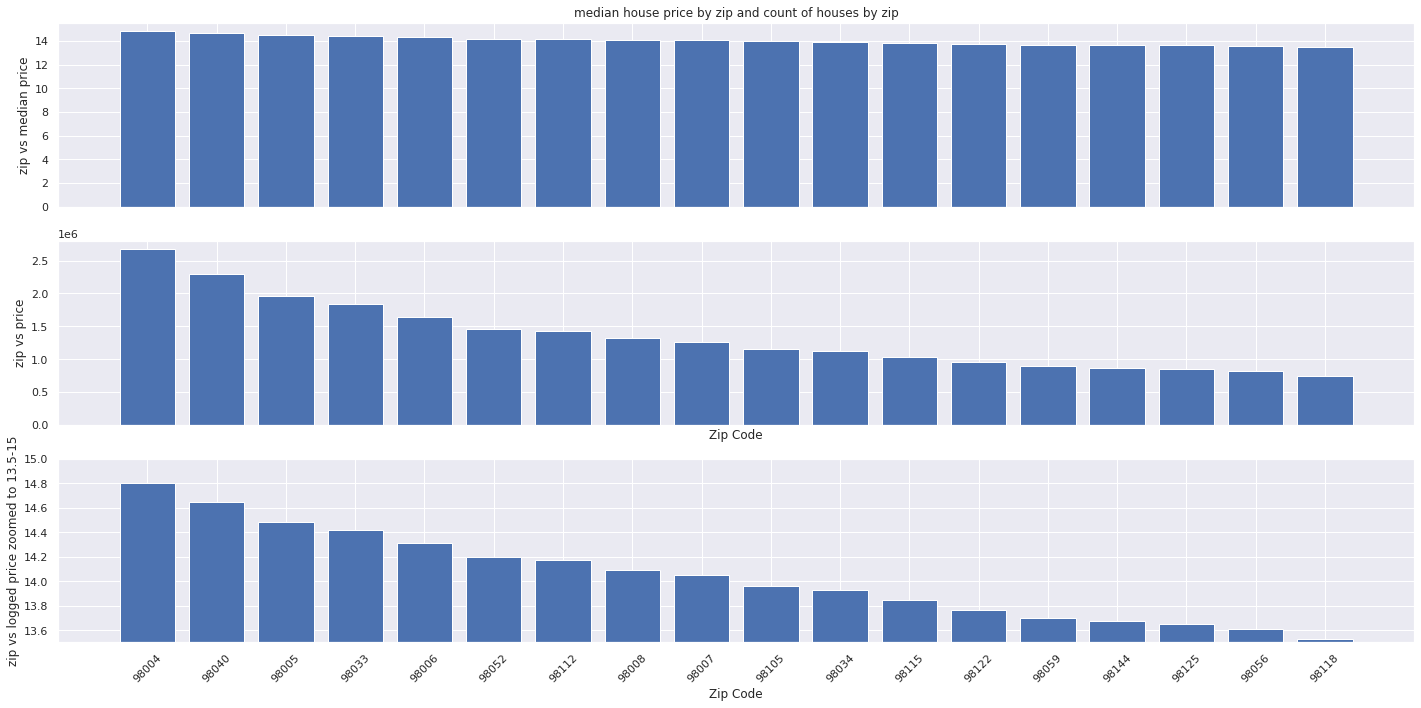

In [33]:
# plot just the nearby zips, both their price and logged price

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(20, 10))

y = [nearby_zip_by_price_median['price'], nearby_zip_by_price_median['count']]
x = nearby_zip_by_price_median['zip']

ax[0].bar(x=x, height=np.log(y[0]))
ax[1].bar(x=x, height=y[0])#y[1])
ax[2].bar(x=x, height=np.log(y[0]))#y[1])



# checking raw price here, convert to log?
ax[0].set(
    title='median house price by zip and count of houses by zip',
    ylabel='zip vs median price'
)
ax[1].set(
    ylabel='zip vs price',
    xlabel='Zip Code',
)
ax[2].set(
    ylim=[13.5,15],#{'min':12.5,'max':14},
    ylabel='zip vs logged price zoomed to 13.5-15',
    xlabel='Zip Code',
)

#dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
#ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
''


In [20]:
zip_model_df = zip_model.tables[1]


In [5]:
# maybe use this maybe don't

# cost_differential_by_zip = zip_model_df.iloc[1:][
#     zip_model_df['P>|t|'] <= alpha
# ].sort_values('Coef.', ascending=False)[
#     ['Coef.', 'Std.Err.']
# ].reset_index().rename(columns={'index': 'zip'})

# cost_differential_by_zip


bellevue/98004 is the highest median zip code, getting the adjacent zip codes

In [ ]:
homes_df.info()


In [ ]:
sns.PairGrid(homes_df.iloc[:, 2:], y_vars='price').map(sns.scatterplot)
''


In [ ]:
homes_df.columns


In [ ]:
# this is a list of all of the columns in the dataframe
X_vals = [
    #    'id',              # mostly useless
    #    'date',            # not useful here' may be later
    #    'price',           # this is y-val, needs dropped to avoid collinearity
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    #    'waterfront',      # dummy
    #    'greenbelt',       # dummy
    #    'nuisance',        # dummy
    #    'view',            # needs dummied
    #    'condition',       # would need to be dummied out
    #    'grade',           # not in a format we can use yet. May fix this.
    #    'heat_source',     # dummy
    #    'sewer_system',    # dummy
    'sqft_above',
    #    'sqft_basement',   # already have the has_xyz columns, may switch back to these
    #    'sqft_garage',     # ^
    #    'sqft_patio',      # ^
    'yr_built',
    'yr_renovated',
    #    'address',         # not numerical, little data is here - may be useful if we do a mapping function
    #    'zip',             # may make this into a cat. column/dummy column later, lots of cats though... (76)
    #    'town',            # dummy if needed
    #    'Zip Codes',       # <= only need/want 1 zip code column
    'has_basement',
    'has_garage',
    'has_patio'
]
X_vals


In [ ]:
homes_df.value_counts('zip').shape


In [ ]:
homes_df.value_counts('town').shape


In [ ]:
homes_df[X_vals]


In [ ]:
y = homes_df['price']
X = sm.add_constant(homes_df[X_vals])
print(sm.OLS(y,
             X).fit().summary())


### Getting OLS for houses by zip code


In [ ]:
zip_by_price_median.iloc[0]['zip']


adj R<sup>2</sup> >0.38 - worth investigation  
several zips with P>|t| < 0.05, shows significance of those zips vs. base zip (most common)  
high abs(coef) in several cases as well, some high std.er, t stat varies


In [ ]:
zip_by_price_median.sort_values(by='count')


In [ ]:
homes_df[['zip', 'price']]


In [ ]:
fig, ax = plt.subplots()
ax.boxplot(homes_df[['zip', 'price']].groupby('zip'))


In [ ]:
pd.set_option('display.max_rows', 30)
homes_df[['town', 'zip', 'price']].sort_values(
    'price', ascending=False).groupby(by=['town', 'zip']).agg('median')


## Narrowing zipcode data


In [ ]:
zip_model_df1.columns


<hr/>


<hr/>


## get_zip(s)() block


define zipcode lookup functions, may not be useful or used - keep for reference


In [ ]:
# TODO: ##################################
# move this to code/ if it proves useful #
##########################################

import geopy  # <= `conda install -c conda-forge geopy`


def get_zip(
    latitude,
    longitude,
    return_errors=False
):
    """_summary_

    Args:
        latitude (float): the latitude of a target address
        longitude (float): the longitude of a target address
        return_errors (bool): whether to return errors or None, useful for "dirty" data. Defaults to False.

    Returns:
        str: string zip/post code of the requested long/lat
    """
    geoloc = geopy.Nominatim(user_agent='check_1')
    try:
        location = geoloc.reverse(f"{latitude},{longitude}")
        return location.raw['address']['postcode']
    except:
        return ValueError() if return_errors else None


def get_zips(
    latitudes,
    longitudes,
    return_errors=False
):
    """_summary_

    Args:
        latitude (list): the latitudes of a target address. Should be a list of floats.
        longitude (list): the longitudes of a target address. Should be a list of floats.
        return_errors (bool, optional): whether to return errors or None, useful for "dirty" data. Defaults to False.

    Returns:
        list: list of zip codes (str) based on latitude and longitude provided
    """
    try:
        if len(latitudes) == len(longitudes):
            location = [get_zip(_lat, _long, return_errors)
                        for (_lat, _long) in zip(latitudes, longitudes)]
            return location
    except:
        if return_errors:
            raise ValueError(f'Error(s) raised in thread: {Exception}')
        else:
            return None


In [ ]:
# display(
#     housing_df[['lat','long']],
#     housing_df[['lat','long']].info()
#     )


In [ ]:
# get_zip(47.449490, -122.18908)


In [ ]:
# get_zips(
#     list(housing_df['lat'])[:10],
#     list(housing_df['long'])[:10],
#     True
#     )


In [ ]:
# ofst = 150
# z = ofst + 0
# slc = ofst + 100
# get_zips(
#     list(housing_df['lat'])[z:slc],
#     list(housing_df['long'])[z:slc],
#     return_errors = False
#     )


<hr/>


In [ ]:
housing_df[housing_df['yr_renovated'] >= 1990]['price'].mean()


In [ ]:
housing_df['price'].mean()


In [ ]:
housing_df[housing_df['yr_renovated'] >= 1990]['price'].mean() - \
    housing_df['price'].mean()


In [ ]:
kc_only['heat_source']


In [ ]:
heating_types = homes_df[['heat_source', 'price']].groupby(
    by='heat_source').agg('mean', 'count')
heating_types


In [ ]:
display(homes_df.info(), homes_df.describe())


In [ ]:
kc_only[kc_only['price'] >= 10000000].value_counts('zip')


In [ ]:
kc_only[kc_only['price'] >= 10000000].sort_values('price', ascending=False)
